# Setup

In [67]:
import matplotlib.pyplot as plt
import sys

# !pip install torchvision
import torch

import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from matplotlib import colors
import os, copy
from PIL import Image

import numpy as np

import sympy

# Get Notes

In [68]:
def midi2List(filename):
    

    from mido import MidiFile

    mid = MidiFile(filename)
    mididict = []
    output = []

    # Put all note on/off in midinote as dictionary.
    for i in mid:
        if i.type == 'note_on' or i.type == 'note_off' or i.type == 'time_signature':
            mididict.append(i.dict())
    # change time values from delta to relative time.
    mem1=0
    for i in mididict:
        time = i['time'] + mem1
        i['time'] = time
        mem1 = i['time']
    # make every note_on with 0 velocity note_off
        if i['type'] == 'note_on' and i['velocity'] == 0:
            i['type'] = 'note_off'
    # put note, starttime, stoptime, as nested list in a list. # format is [type, note, time, channel]
        mem2=[]
        if i['type'] == 'note_on' or i['type'] == 'note_off':
            mem2.append(i['type'])
            mem2.append(i['note'])
            mem2.append(i['time'])
            mem2.append(i['channel'])
            output.append(mem2)
    # put timesignatures
        if i['type'] == 'time_signature':
            mem2.append(i['type'])
            mem2.append(i['numerator'])
            mem2.append(i['denominator'])
            mem2.append(i['time'])
            output.append(mem2)

    return output

In [69]:
def note_number_to_name(note_number):
    
    """Convert a MIDI note number to its name, in the format
    ``'(note)(accidental)(octave number)'`` (e.g. ``'C#4'``).
    
    https://github.com/craffel/pretty-midi/blob/main/pretty_midi/utilities.py
    
    Parameters
    ----------
    note_number : int
        MIDI note number.  If not an int, it will be rounded.
    Returns
    -------
    note_name : str
        Name of the supplied MIDI note number.
    Notes
    -----
        Thanks to Brian McFee.
    """

    # Note names within one octave
    semis = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

    # Ensure the note is an int
    note_number = int(np.round(note_number))

    # Get the semitone and the octave, and concatenate to create the name
    return semis[note_number % 12] + str(note_number//12 - 1)

In [70]:
notes_info_list = midi2List('data/vocal.mid')
notes = []
for info in notes_info_list:
    if info[0] == 'note_on':
        notes.append(note_number_to_name(info[1])[:-1])

In [71]:
notes

['D',
 'D',
 'A',
 'A',
 'A#',
 'G',
 'E',
 'E',
 'F',
 'E',
 'D',
 'C',
 'E',
 'C#',
 'D',
 'D',
 'D',
 'C#',
 'A#',
 'G#',
 'A#',
 'A',
 'G',
 'D',
 'F',
 'E',
 'E',
 'E',
 'C#',
 'E',
 'E',
 'C',
 'F',
 'D',
 'F',
 'F',
 'G',
 'G#',
 'D',
 'C#',
 'A#',
 'F',
 'E',
 'F',
 'C#',
 'D#',
 'F',
 'F',
 'F',
 'D',
 'F',
 'F',
 'F',
 'D#',
 'E',
 'E',
 'D',
 'D',
 'D',
 'F',
 'D',
 'D',
 'F',
 'D',
 'F',
 'F',
 'F',
 'A#',
 'C#',
 'D#',
 'C',
 'D',
 'E',
 'A',
 'A',
 'G',
 'D',
 'E',
 'E',
 'F',
 'E',
 'C#',
 'E',
 'C#',
 'E',
 'C#',
 'E',
 'C#',
 'E',
 'D',
 'C#',
 'G#',
 'A',
 'A#',
 'A',
 'G',
 'F',
 'D',
 'D',
 'D',
 'F',
 'E',
 'F',
 'E',
 'D',
 'C#',
 'E',
 'E',
 'D',
 'C',
 'F',
 'D',
 'F',
 'F',
 'G',
 'A',
 'D',
 'C#',
 'A#',
 'D',
 'C',
 'F',
 'E',
 'G',
 'F#',
 'A',
 'G#',
 'B',
 'F',
 'F',
 'D',
 'E',
 'C#',
 'F',
 'F',
 'D#',
 'F',
 'F',
 'E',
 'E',
 'E',
 'E',
 'D',
 'D',
 'D',
 'D',
 'C#',
 'D',
 'F',
 'D#',
 'F',
 'F',
 'D#',
 'B',
 'D',
 'E',
 'A',
 'F',
 'G#',
 'A',
 'F',


# Generate a color map

In [72]:
"""
Define a dictionary showing the mapping between the note and a color

One possible mapping is the Scriabin keys - https://en.wikipedia.org/wiki/Clavier_%C3%A0_lumi%C3%A8res
"""

scriabinDict = {"C":"#ff0000", "C#": "#cf9bff", "D": "#ffff00", "D#":"#65659a", "E": "#e4fbff", "F": "#ae1600", "F#": "#00cdff", "G": "#ff6500", "G#": "#ff00ff", "A": "#30cd30", "A#": "#8d8b8d", "B": "#0000fe"}
#scriabinDict
cleanNotes = notes

In [73]:
"""
Convert the list of notes into a list of corresponding hex values
"""

hexList = []

for note in cleanNotes:
    for notekey, notehex in scriabinDict.items():
        if note == notekey:
            hexList.append(notehex)
            
#hexList

In [74]:
"""
Function to find the 'best' factor pair

The aim is to create a rectangular grid, each cell containing colors from the list. 

The rectangle closest to looking like an image is one that is neither too tall or too wide. This means a length and
breadth that are closest to each other. 

This function calculates all the possible pairs of factors for the length of the list and picks the pair that has 
the least difference between the numbers of the pair
"""

def findBestFactorPair(n): 
    newdiff = 10000
    for i in range(1, int(pow(n, 1 / 2))+1): 
        if n % i == 0: 
            if ((n/i)-i)<newdiff:
                xfact = i
                yfact = n/i
    return xfact,int(yfact)

In [75]:
"""
Call the function to find the length and breadth of the rectangular grid we are going to create

But before we do that, in order to avoid prime number lengths, the list popped is once if the length of the list is
an odd number. 

This might sound wonky but it feels much faster compared to actually checking for a prime number and handling that
case, especially when we are obfuscating the image a bunch. Therefore the length of the list will always be even.

TODO - In case the implementation of the note-grabbing gets really accurate we might need to change this to reflect
a similar level of accuracy.
"""

if len(hexList)%2 != 0:
    hexList.pop()

xfact,yfact = findBestFactorPair(len(hexList))

In [76]:
import random

try:
    print("Reshape",xfact, yfact)
    sample_size = 500
    hexList = [hexList[i] for i in sorted(random.sample(range(len(hexList)), sample_size))]
    xfact = 20
    yfact = 25
    print("Reshaped to",xfact, yfact)
except:
    if sympy.isprime(yfact):
        yfact -= 2
        num = xfact*yfact
        xfact, yfact = findBestFactorPair(num)
        numToReduce = num - len(hexList)
        hexList = hexList[:numToReduce]
        print("Reshaped to",xfact, yfact)

Reshape 4 107
Reshaped to 20 21


In [77]:
print(xfact, yfact)
print(len(hexList))

20 21
420


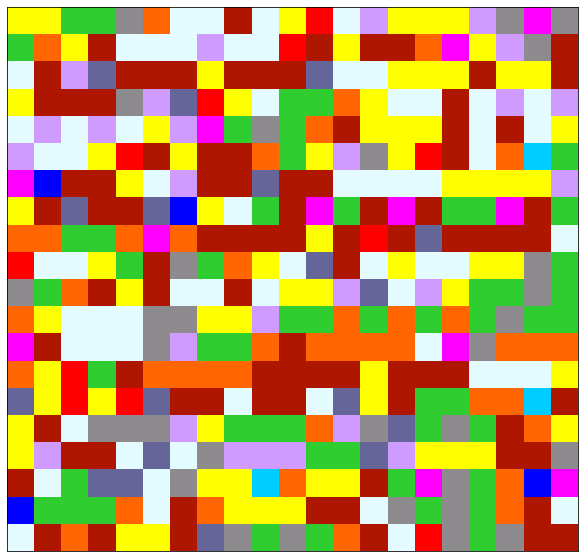

In [78]:
"""
Time to get the grid up!

Doing a bunch of stuff with matplotlib so that it ends up with a big image that doesn't have those pesky ticks and
labels

The final image is written onto a file called "Grid.png" at the same level as this notebook
"""

from matplotlib.colors import to_rgba_array

plt.figure(figsize=(20, 10))

plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

plt.imshow(to_rgba_array(hexList).reshape(xfact,yfact,4))

plt.savefig('Grid.png', bbox_inches='tight')

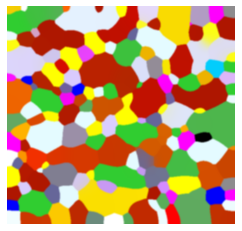

In [79]:
"""
Here's the wobbly bit. We're doing a bunch of fuckery with this grid. 

The #Intial Pass is meant to get as close to the targeted aesthetic as possible
The #Smoothening Pass is meant to give it a more blurred, muted look

Both of these passes involve the oilPainting, stylization(for watercolor) and a Gaussian blur

TODO - Stop winging this
"""
# !pip uninstall -y opencv-python
# !pip uninstall -y opencv-contrib-python
# !pip install opencv-contrib-python
import cv2
img = cv2.imread('Grid.png')
res = img

#Initial Pass
for i in range(5):
    res = cv2.xphoto.oilPainting(res, 7, 1)
    res = cv2.stylization(res, sigma_s=60, sigma_r=0.6)
    res = cv2.xphoto.oilPainting(res, 7, 1)
    res = cv2.blur(res,(5,5))
  
#Smoothening Pass
for i in range(20):
    res = cv2.xphoto.oilPainting(res, 7, 1)
    res = cv2.blur(res,(5,5))
        
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.savefig('Outputs/Grid_artistic.png')

# Neural Network to generate a pattern map

In [80]:
def init_normal(m):
    if type(m) == nn.Linear:        
        nn.init.normal_(m.weight)


class NN(nn.Module):

    def __init__(self, activation=nn.Tanh, num_neurons=16, num_layers=9):
        """
        num_layers must be at least two
        """
        super(NN, self).__init__()
        
        layers = [nn.Linear(2, num_neurons, bias=True), activation()]
        for _ in range(num_layers - 1):
            layers += [nn.Linear(num_neurons, num_neurons, bias=False), activation()]
        layers += [nn.Linear(num_neurons, 3, bias=False), nn.Sigmoid()]
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


def gen_new_image(size_x, size_y, save=True, **kwargs):
    
    net = NN(**kwargs)
    net.apply(init_normal)
    colors = run_net(net, size_x, size_y)
    
    plot_colors(colors)
    if save is True:
        filename = save_colors(colors)
        
    return net, colors, filename


def run_net(net, size_x=128, size_y=128):
    x = np.arange(0, size_x, 1)
    y = np.arange(0, size_y, 1)
    colors = np.zeros((size_x, size_y, 2))
    for i in x:
        for j in y:
            colors[i][j] = np.array([float(i) / size_y - 0.5, float(j) / size_x - 0.5])
    colors = colors.reshape(size_x * size_y, 2)
    img = net(torch.tensor(colors).type(torch.FloatTensor)).detach().numpy()
    return img.reshape(size_x, size_y, 3)


def plot_colors(colors, fig_size=4):
    plt.figure(figsize=(fig_size, fig_size))
    plt.imshow(colors, interpolation='nearest', vmin=0, vmax=1)


def save_colors(colors):
    filename = str(np.random.randint(100000)) + ".png"
    filepath = 'Outputs/' + filename
    plt.imsave(filepath, colors)
    return filename


def run_plot_save(net, size_x, size_y, fig_size=8):
    colors = run_net(net, size_x, size_y)
    plot_colors(colors, fig_size)
    save_colors(colors)

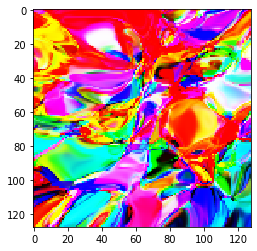

In [81]:
#Set num_neurons as 10, 16, 20 or 28 based on tempo buckets

n,c, pattern_map = gen_new_image(128, 128, save=True, num_neurons=28, num_layers=9)

# Blend the color and the pattern map

In [82]:
!echo $pattern_map

40180.png


In [83]:
current_path = !pwd
current_path = current_path[0]
mount_path = current_path+'/Outputs'
mount_path

'/home/srishankar/Documents/synethetizer/Outputs'

In [84]:
!echo $mount_path:out

/home/srishankar/Documents/synethetizer/Outputs:out


In [86]:
!podman run -v $mount_path:/out -it ffedoroff/neural-style th neural_style.lua -gpu -1 -style_image Grid_artistic.png -content_image $pattern_map